In [19]:
# TODO: Edit/run this on all 55,000 rows, not just the top 10,000

from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def expression_dataframe(spec_donors=[],reject_donors=[],donor_sex=None,donor_age=[],output_name=None):
    
    #        This function constructs a dataframe of all RPKM data for desired donors/ages/sexes
    #        Most of the code is copied from functions in PCA_and_plot/average_expression_by_tissue, so look there 
    #        for details.

    # DONORS BY ID
    if not spec_donors:
        all_donors = open('../data/donors_list.txt')
        donor_list = [ID[0:-1] for ID in all_donors if ID[0:-1] not in reject_donors]
        all_donors.close()
    else:
        donor_list = spec_donors
    # dictionary of donor IDs, and an array that will be [sex,age]
    donor_dict = dict((ID,[]) for ID in donor_list)

    # DONORS BY AGE AND SEX
    donor_info = open('../data/donor_info.txt')
    for line in donor_info:
        # info is [ID,sex,age,death]
        info = line.split('\t')
        if info[0] in donor_list:
            # check sex
            if donor_sex and info[1] != donor_sex:
                del donor_dict[info[0]]
                continue
            else:
                donor_dict[info[0]].append(info[1])
            # check age    
            age = info[2].split('-')[0]
            if donor_age and age not in donor_age:
                del donor_dict[info[0]]
                continue
            else:
                donor_dict[info[0]].append(age)
    donor_info.close()

    # CONSTRUCT MATRIX
    total_matrix = np.zeros((10000,0))
    total_tissues = []

    # metadata on relevant points
    for ID in donor_dict.keys():
        metafile = open('../data/Donor_Metadata_Enhanced/donor_meta_'+ID+'.txt')
        next(metafile)
        next(metafile)
        next(metafile)
        next(metafile)
        # tissue type of each column
        donor_tissues = []
        for line in metafile:
            tissue = line.split('\t')[1]
            donor_tissues.append(tissue)
        metafile.close()
        # get data
        donor_matrix = np.zeros((10000,len(donor_tissues)))
        row = 0
        donorfile = open('../data/donor_matrices_fixed/donor_'+ID+'.txt')
        for line in donorfile:
            # add each row to donor matrix
            donor_matrix[row,:] = line.split('\t')
            row = row+1
        # add this donor to total matrix
        total_matrix = np.concatenate((total_matrix, donor_matrix), axis=1)
        total_tissues.extend(donor_tissues)
        donorfile.close()
    
    df_all = pd.DataFrame(total_matrix,columns=total_tissues)
    # save to file
    if output_name:
        df_all.to_csv(output_name,sep='\t')
        print 'Dataframe saved as ' + output_name
    return df_all

In [40]:
def sample_variance_by_tissue(df_all,output_name = None):
    #        This function takes a dataframe and creates a new dataframe with a column for each tissue
    #        and a row for each of the following:
    #            - number of samples of that tissue
    #            - average variance of expression of transcripts across samples of that tissue
    #            - variance of variances of expression of transcripts across samples of that tissue
    #            - maximum pairwise euclidean distance of samples of that tissue
    #        It also makes a dataframe with the variance of each transcript across samples of each tissue.
    
    
    tissues = set(df_all.columns.values)
    df_stats = pd.DataFrame(index = ['n_samples','avg_var','var_var','max_dist'],columns=tissues)
    df_vars = pd.DataFrame(columns = tissues)

    for tissue in tissues:
        # variance dataframe
        df_tissue = df_all[tissue]
        df_vars[tissue] = df_tissue.var(axis=1)
        n_cols = df_tissue.shape[1]
        df_stats.loc['n_samples',tissue] = n_cols
        df_stats.loc['avg_var',tissue] = df_tissue.var(axis=1).mean(axis=0)
        df_stats.loc['var_var',tissue] = df_tissue.var(axis=1).var(axis=0)
        
        distance = 0
        for col1 in range(n_cols):
            for col2 in range(col1+1,n_cols):
                dist = np.linalg.norm(df_tissue.iloc[:,col1] - df_tissue.iloc[:,col2])
                if dist > distance:
                    distance = dist
        df_stats.loc['max_dist',tissue] = distance
    
    # save to file
    if output_name:
        df_stats.to_csv(output_name,sep='\t')
        print 'Dataframe saved as ' + output_name
    return df_stats,df_vars

In [41]:
#df_all = expression_dataframe()
[df_stats,df_vars] = sample_variance_by_tissue(df_all,output_name='../csv_output_files/variance_stats.csv')

Dataframe saved as ../csv_output_files/variance_stats.csv


n_samples            393
avg_var      1.27611e+07
var_var      6.80041e+17
max_dist      1.4621e+06
Name: Whole Blood, dtype: object


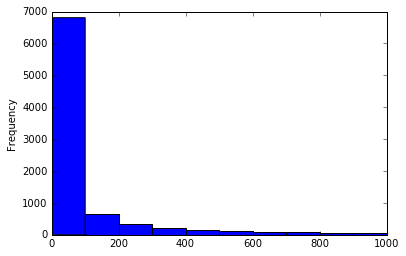

In [57]:
print df_stats['Whole Blood']
df_vars['Whole Blood'].plot.hist(bins=10,range=(0,1000))

n_samples            103
avg_var           233017
var_var      1.22611e+14
max_dist          193708
Name: Pituitary, dtype: object


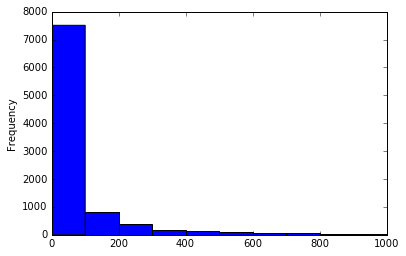

In [58]:
print df_stats['Pituitary']
df_vars['Pituitary'].plot.hist(bins=10,range=(0,1000))

n_samples           193
avg_var          632482
var_var      5.8836e+14
max_dist         243367
Name: Stomach, dtype: object


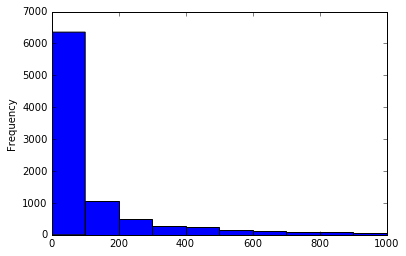

In [59]:
print df_stats['Stomach']
df_vars['Stomach'].plot.hist(bins=10,range=(0,1000))